# Doc2Vec
We take snippets of books and **train a doc2vec model** on them.

Next, we explore **most similar documents** to 2 selected documents. Do these documents come from the same author? Do they have same genre?

In the following, we project the document vectors to 2D using **PCA** and **t-SNE** and plot them. Are documents written by the same author close to each other? Can we observe clusters based on genres?


In [40]:
import sys
import logging
import numpy as np
import pandas as pd
import pickle
import os
import collections

from gensim.models import Doc2Vec

sys.path.append('..')
logging.getLogger().setLevel('DEBUG')

### Load documents

In [27]:
def load_documents(SKIP_FIRST_N_WORDS, WORDS_IN_DOCUMENT, SAMPLES_PER_DOCUMENT):
    documents=[]
    part=0
    while True:
        filepath = '../res/documents_{}_{}_{}_part{}.pkl'.format(
            SKIP_FIRST_N_WORDS, WORDS_IN_DOCUMENT, SAMPLES_PER_DOCUMENT, part)
        if not os.path.exists(filepath):
            break
        documents += pickle.load(open(filepath,'rb'))
        logging.info("Part {} loaded, {} documents".format(part, len(documents)))
        part += 1
    return documents

In [28]:
SKIP_FIRST_N_WORDS = 500
WORDS_IN_DOCUMENT = [500,2000]
SAMPLES_PER_DOCUMENT = 10

In [29]:
documents = load_documents(SKIP_FIRST_N_WORDS, WORDS_IN_DOCUMENT, SAMPLES_PER_DOCUMENT)

INFO:root:Part 0 loaded, 50000 documents
INFO:root:Part 1 loaded, 100000 documents
INFO:root:Part 2 loaded, 150000 documents
INFO:root:Part 3 loaded, 166798 documents


### Load trained doc2vec model

In [30]:
doc2vec = Doc2Vec.load('../res/model_{}_{}_{}.model'.format(SKIP_FIRST_N_WORDS, WORDS_IN_DOCUMENT, SAMPLES_PER_DOCUMENT))

INFO:gensim.utils:loading Doc2Vec object from ../res/model_500_[500, 2000]_10.model
DEBUG:smart_open.smart_open_lib:{'kw': {}, 'mode': 'rb', 'uri': '../res/model_500_[500, 2000]_10.model'}
DEBUG:smart_open.smart_open_lib:encoding_wrapper: {'errors': 'strict', 'encoding': None, 'mode': 'rb', 'fileobj': <_io.BufferedReader name='../res/model_500_[500, 2000]_10.model'>}
INFO:gensim.utils:loading vocabulary recursively from ../res/model_500_[500, 2000]_10.model.vocabulary.* with mmap=None
INFO:gensim.utils:loading trainables recursively from ../res/model_500_[500, 2000]_10.model.trainables.* with mmap=None
INFO:gensim.utils:loading syn1neg from ../res/model_500_[500, 2000]_10.model.trainables.syn1neg.npy with mmap=None
INFO:gensim.utils:loading wv recursively from ../res/model_500_[500, 2000]_10.model.wv.* with mmap=None
INFO:gensim.utils:loading vectors from ../res/model_500_[500, 2000]_10.model.wv.vectors.npy with mmap=None
INFO:gensim.utils:loading docvecs recursively from ../res/model_

As the documents are 0 indexed in Doc2Vec, we create a lookup table to keep track of document ids.

In [34]:
lookup_table = dict()
for n, (tokens, key) in enumerate(documents):
    lookup_table[key[0]] = n
    
book_ids = np.array(list(lookup_table.keys()))
book_ids_catalog = [int(b.split('_')[0]) for b in book_ids]

filepath = '../res/bookids{}_{}_{}.pkl'.format(SKIP_FIRST_N_WORDS, WORDS_IN_DOCUMENT, SAMPLES_PER_DOCUMENT)
    
pickle.dump(book_ids,open(filepath,'wb'))

### Fetch metadata catalog
- as we have multiple documents per book, we duplicate catalog entries for each document

In [35]:
from src.utils import load_catalog
metadata_catalog_0 = load_catalog()
metadata_catalog_0 = metadata_catalog_0[metadata_catalog_0.index.isin(book_ids_catalog)]

metadata_catalog = pd.DataFrame(columns=metadata_catalog_0.columns, index=book_ids)

for b in book_ids:
    metadata_catalog.loc[b] = metadata_catalog_0.loc[int(b.split('_')[0])]
print(metadata_catalog.shape)
metadata_catalog.head(5)

(166798, 10)


,author,title,downloads,formats,type,LCC,subjects,authoryearofbirth,authoryearofdeath,language
38254_0,"Chapman, Allen","Bart Keene's Hunting Days; or, The Darewell Ch...",7,{'application/epub+zip': 'http://www.gutenberg...,Text,{PZ},"{Camping -- Juvenile fiction, Hunting stories}",NaN,NaN,[en]
38254_1,"Chapman, Allen","Bart Keene's Hunting Days; or, The Darewell Ch...",7,{'application/epub+zip': 'http://www.gutenberg...,Text,{PZ},"{Camping -- Juvenile fiction, Hunting stories}",NaN,NaN,[en]
38254_2,"Chapman, Allen","Bart Keene's Hunting Days; or, The Darewell Ch...",7,{'application/epub+zip': 'http://www.gutenberg...,Text,{PZ},"{Camping -- Juvenile fiction, Hunting stories}",NaN,NaN,[en]
38254_3,"Chapman, Allen","Bart Keene's Hunting Days; or, The Darewell Ch...",7,{'application/epub+zip': 'http://www.gutenberg...,Text,{PZ},"{Camping -- Juvenile fiction, Hunting stories}",NaN,NaN,[en]
38254_4,"Chapman, Allen","Bart Keene's Hunting Days; or, The Darewell Ch...",7,{'application/epub+zip': 'http://www.gutenberg...,Text,{PZ},"{Camping -- Juvenile fiction, Hunting stories}",NaN,NaN,[en]


### Clean the genre attribute in metadata
- we are interested in 10 genres, namely:
  - short stories
  - science fiction
  - history
  - conduct of life
  - drama
  - poetry
  - detective and mystery stories
  - biography
  - western stories
  - children's stories

In [42]:
c = [subject.lower().strip() for subjects in metadata_catalog.subjects for subject in subjects]
# split genre tags at "--"
c2 = [simple_subject.strip() for complex_subject in c for simple_subject in complex_subject.split('--')]
# split genre tags at ","
c3 = [simple_subject.strip() for complex_subject in c2 for simple_subject in complex_subject.split(',')]

collections.Counter(c3).most_common(20)

[('fiction', 145972),
 ('juvenile fiction', 104634),
 ('short stories', 14539),
 ('social life and customs', 12471),
 ('19th century', 12277),
 ('england', 12187),
 ('history', 12103),
 ('science fiction', 11299),
 ('drama', 11232),
 ('conduct of life', 11105),
 ('translations into english', 8819),
 ('poetry', 7212),
 ('english', 7125),
 ('united states', 5919),
 ('great britain', 5544),
 ('adventure stories', 5452),
 ('american', 5152),
 ('detective and mystery stories', 5054),
 ('love stories', 5030),
 ('biography', 4200)]

Chosing genres to classify on. Didn't take *fiction* and *juvenile fiction* as these might be too general.

In [43]:
selected_genres = ['short stories',
                  'science fiction',
                  'history',
                  'conduct of life',
                  'drama',
                  'poetry',
                  'detective and mystery stories',
                  'biography',
                  'western stories',
                  'children\'s stories']

Documents having exactly one genre out of `specified genres` are given that genre. Documents having more than one of genres in `selected genres` or none of them are set to *other* and will be not used for classifying.

In [45]:
def modify_genres(genre_set):
    if len(genre_set) == 0:
        return set()
    result_set = set()
    for s in genre_set:
        result_set = result_set.union(set([x.split(',')[0].lower().strip() for x in s.split('--')]))
    return result_set

metadata_catalog['modified_genres'] = metadata_catalog.subjects.apply(modify_genres)


genres = metadata_catalog['modified_genres'].apply(
    lambda x: tuple(x.intersection(selected_genres))
      if len(x.intersection(selected_genres))>=1 else tuple(['other']))

selected_genre_mask = genres != tuple(['other'])
genres_selected = genres[selected_genre_mask]
genres.value_counts()

(other,)                                                          105389
(history,)                                                          8977
(short stories,)                                                    8391
(conduct of life,)                                                  6355
(science fiction,)                                                  5921
(poetry,)                                                           5827
(science fiction, short stories)                                    5138
(detective and mystery stories,)                                    4794
(drama,)                                                            3659
(western stories,)                                                  3500
(biography,)                                                        2810
(children's stories,)                                               2047
(children's stories, conduct of life)                                884
(drama, history)                                   

In [47]:
docvecs = np.array([doc2vec.docvecs[book_id] for book_id in book_ids])
# docvecs = np.array([model.infer_vector(documents[lookup_table[book_id]][0]) for book_id in book_ids])

# CLASSIFIERS

In [186]:
from matplotlib import pyplot as plt
from IPython.display import clear_output
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import keras
from keras import Sequential, regularizers
from keras.layers import Dense

### Prepare output for NN
- 10-dim vector as we classify into 10 genres (multiple genres possible)

In [143]:
mlb = MultiLabelBinarizer()
genres_binarized = mlb.fit_transform(genres[selected_genre_mask])
genres_binarized.shape

(61409, 10)

In [144]:
X_train, X_test, y_train, y_test, ids_train, ids_test = train_test_split(docvecs[selected_genre_mask],
                                                                         genres_binarized,
                                                                         book_ids[selected_genre_mask],
                                                                         random_state=42)

In [145]:
model_nn = Sequential()
model_nn.add(Dense(200, activation='relu', input_shape=(200,), kernel_regularizer=regularizers.l2(0.002)))
model_nn.add(Dense(100,activation='relu', kernel_regularizer=regularizers.l2(0.002)))
model_nn.add(Dense(10,activation='sigmoid', kernel_regularizer=regularizers.l2(0.002)))

In [146]:
print(model_nn.summary())

model_nn.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_23 (Dense)             (None, 200)               40200     
_________________________________________________________________
dense_24 (Dense)             (None, 100)               20100     
_________________________________________________________________
dense_25 (Dense)             (None, 10)                1010      
Total params: 61,310
Trainable params: 61,310
Non-trainable params: 0
_________________________________________________________________
None


In [147]:
EPOCHS = 50
STEP = 5
BATCH_SIZE = 512

### Callbacks for the NN model
- updatable plot
- early stopping

In [148]:
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):

        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
        self.i += 1
        
        clear_output(wait=True)
        
        fig,ax = plt.subplots(1,2, figsize=(15,8))
        
        ax[0].plot(self.x, self.losses, label="loss")
        ax[0].plot(self.x, self.val_losses, label="val_loss")
        ax[0].legend()
        ax[0].set_xlabel('epoch')
        ax[0].set_ylabel('loss')
        ax[0].set_title("Loss")
        
        ax[1].plot(self.x, self.acc, label="acc")
        ax[1].plot(self.x, self.val_acc, label="val_acc")
        ax[1].legend()
        ax[1].set_xlabel('epoch')
        ax[1].set_ylabel('accuracy')
        ax[1].set_title("Accuracy")
        
        plt.show();
        
plot_losses = PlotLosses()

In [149]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=6,
                              verbose=2, mode='auto')

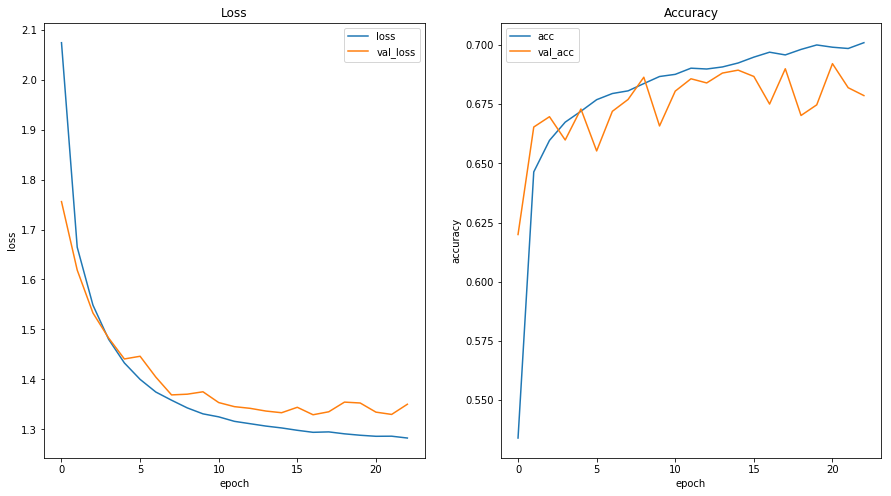

Epoch 00023: early stopping


In [150]:
history = model_nn.fit(X_train, y_train,
          epochs=EPOCHS,
          batch_size=BATCH_SIZE,
          validation_data=(X_test, y_test),
          callbacks=[plot_losses, early_stopping],
          verbose=0)

### Evaluate
- show f1_score and accuracy on train and test
- confusion matrix between genres

                   train_f1-macro test_f1-macro train_accuracy test_accuracy
NN_after_22_epochs        0.69802      0.678263       0.703322      0.682782


,biography,children's stories,conduct of life,detective and mystery stories,drama,history,poetry,science fiction,short stories,western stories
biography,450,4,32,5,10,113,54,4,34,7
children's stories,5,175,267,1,1,41,9,4,11,4
conduct of life,13,51,1246,23,10,155,21,7,55,27
detective and mystery stories,9,0,138,757,2,147,1,25,91,53
drama,21,1,21,2,785,60,53,1,8,2
history,61,11,221,42,18,1731,32,7,86,40
poetry,48,11,29,0,29,75,1219,5,19,6
science fiction,8,1,35,36,0,83,6,1166,99,21
short stories,59,30,384,110,24,457,42,51,776,114
western stories,4,1,71,25,2,84,4,5,61,649


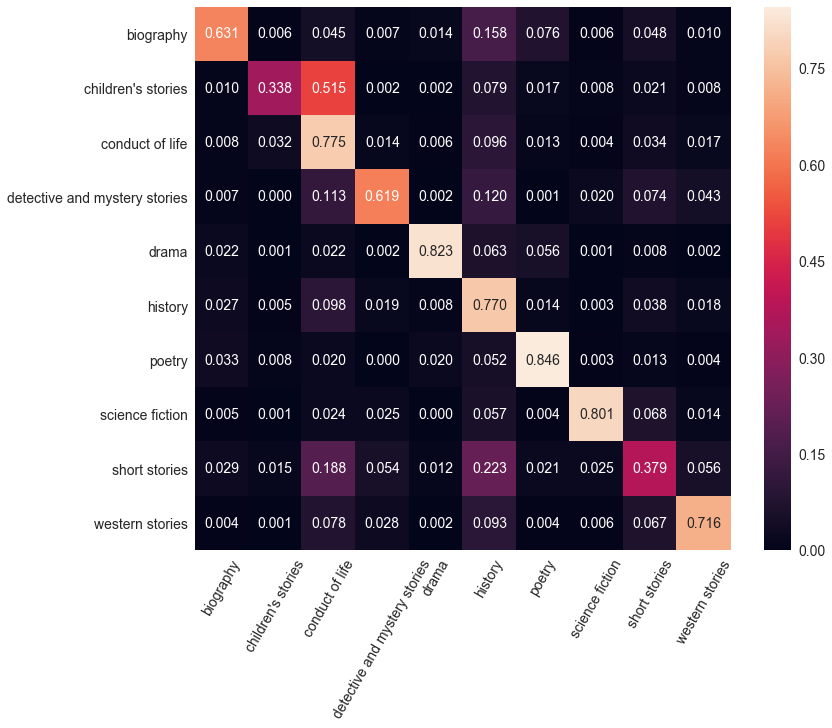

In [207]:
genre_results = pd.DataFrame(columns=['train_f1-macro','test_f1-macro','train_accuracy','test_accuracy'])
clf = model_nn

clf_name = 'NN_after_{}_epochs'.format(early_stopping.stopped_epoch)

train_single_class_mask = (y_train.sum(axis=1) == 1)
test_single_class_mask = (y_test.sum(axis=1) == 1)

y_train2 = mlb.classes_[y_train[train_single_class_mask].argmax(axis=1)]
y_test2 = mlb.classes_[y_test[test_single_class_mask].argmax(axis=1)]

y_pred_train_multi = clf.predict(X_train[train_single_class_mask])
y_pred_train = mlb.classes_[y_pred_train_multi.argmax(axis=1)]

y_pred_test_multi = clf.predict(X_test[test_single_class_mask])
y_pred_test = mlb.classes_[y_pred_test_multi.argmax(axis=1)]

f1_score_macro_train = f1_score(y_train2, y_pred_train, average='macro')
accuracy_score_train = accuracy_score(y_train2, y_pred_train)
f1_score_macro_test = f1_score(y_test2, y_pred_test, average='macro')
accuracy_score_test = accuracy_score(y_test2, y_pred_test)
genre_results.loc[clf_name,:] = [f1_score_macro_train, f1_score_macro_test, accuracy_score_train, accuracy_score_test]

genre_results.sort_values(['test_f1-macro'], ascending=False, inplace=True)
print(genre_results)

conf_matrix = pd.DataFrame(confusion_matrix(y_test2, y_pred_test), index=mlb.classes_, columns=mlb.classes_)

# plot confusion matrix as a heatmap
sns.set(font_scale=1.4)
fig, ax = plt.subplots(1,1, figsize=(12,10))
row_sums = np.full_like(conf_matrix,conf_matrix.sum(axis=1).values).T
hm = sns.heatmap(conf_matrix / row_sums, annot=True, annot_kws={"size": 14}, fmt=".3f", ax=ax)
hm.set_xticklabels(hm.get_yticklabels(), rotation=60)
# display a table
conf_matrix

# SUMMARY
We used doc2vec embeddings of the documents as input and trained a feed forward neural network which reaches around 70 % accuracy and f1_score for genre classification. (Only documents belonging to exactly one of the selected genres where selected for evaluation).

- biggest misclasification happened between children's stories and conduct of life
  - it might be hard to distinguish them as they both have an educational aspect